In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = colors.values()

plt.style.use('style.mpl')

In [2]:
# Load E. coli growth rates from Schmidt et al. 2016
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
mask = np.logical_and(
    coli_data.dataset.str.contains('schmidt'),
    coli_data.growth_mode != 'chemostat') 
stress_conds = 'pH6,osmotic_stress_glucose,42C'.split(',')
mask = np.logical_and(mask, ~coli_data.condition.isin(stress_conds))
coli_csource_df = coli_data[mask].sort_values('growth_rate_hr')
coli_csource_df.condition.replace({'glycerol_pAA': 'glycerol + AA', 'lb_miller': 'LB'}, inplace=True)

In [3]:
# Manually curated collection of fast growers
fast_growers_df = pd.read_csv('../data/physiology/fastest_growers.csv')
# Filter out the ones we don't want to plot, aggregate remainder by species and DOI
agg_dict = {
    'group': 'first',
    'category': 'first',
    'generation_time_hr': 'mean',
    'growth_rate_hr': 'mean',
    'tmp_C': 'first',
    'growth_mode': 'first',
    'high_CO2': 'first',
    'light': 'first',
}
fast_growers_df = fast_growers_df[fast_growers_df.to_plot].groupby(
    'short_name,DOI'.split(',')).agg(agg_dict).reset_index()

# Add color and positional information
my_colors = 'purple,green'.split(',')
pal = [colors[c] for c in my_colors]

np.random.seed(42)
fast_growers_df['xpos'] = fast_growers_df['group'].map({'autotroph': 1, 'heterotroph': 0})
fast_growers_df['xpos'] += np.random.uniform(-0.2, 0.2, size=fast_growers_df.xpos.size)
color_map = {'Cyanobacteria': colors['green'], 'Eukaryotic alga': colors['dark_green'], 
             'Heterotrophic bacteria': colors['purple'], 'Chemoautotroph': colors['yellow']}
fast_growers_df['color'] = fast_growers_df.category.map(color_map)
fast_growers_df['marker'] = fast_growers_df.short_name.map(
    {'C. ohadii': 'o', 'V. natrigens': '^', 'S. elongatus PCC 11801': '>', 'T. crunogena': '<',
     'E. coli': 'h', 'C. perfingens': 'd'})

# Chemostat example. Maximum growth rate exists.
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Metabolic modes of E. coli
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

In [4]:
mask = np.logical_and(kayser_chemostat_df.D_per_h.notnull(),
                      kayser_chemostat_df.r_glucose_mmol_g_h.notnull())
masked_kayser = kayser_chemostat_df[mask]
kayser_regression = linregress(masked_kayser.D_per_h, masked_kayser.r_glucose_mmol_g_h)
kayser_regression

LinregressResult(slope=9.330509186719699, intercept=0.16059826890195206, rvalue=0.9960383317181503, pvalue=6.487887131442609e-13, stderr=0.2511634516689206, intercept_stderr=0.0669850545879041)

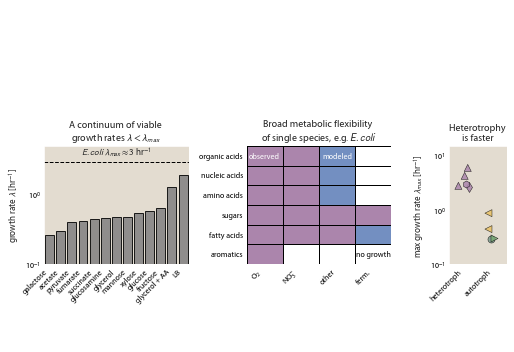

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.24, 5), 
                        gridspec_kw={'width_ratios': [1, 1, 0.4], 'height_ratios':[0.75, 1, 0.25]})

# Clear first and last row.
for row in [0, 2]:
    for ax in axs[row,:]:
        plt.sca(ax)
        plt.axis('off')


# Panel on maximum growth rate -- E. coli growth rates by C-source from Schmidt 2016.
plt.sca(axs[1,0])
plt.yscale('log')
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(3.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 5)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')
plt.text(6, 3.2, '$E. coli$ $\lambda_{max} \\approx 3$ hr$^{-1}$', va='bottom', ha='center', fontsize=9)

plt.ylabel('growth rate $\lambda$ [hr$^{-1}$]')
plt.xlabel('')

# Panel on range of metabolic modes. 
plt.sca(axs[1,1])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.title('Broad metabolic flexibility \nof single species, e.g. $E. coli$')
plt.text(0.5, 0.5, 'observed', ha='center', va='center', fontsize=8, color='w')
plt.text(2.5, 0.5, 'modeled', ha='center', va='center', fontsize=8, color='w')
plt.text(3.5, 5.5, 'no growth', ha='center', va='center', fontsize=8, color='k')

plt.sca(axs[1,2])

plt.yscale('log')
for short_name, gdf in fast_growers_df.groupby('short_name'):
    plt.scatter(gdf.xpos.values, gdf.growth_rate_hr.values,
                color=gdf.color.values, marker=gdf.marker.values[0],
                s=50, lw=0.5, edgecolor='k', alpha=0.85)

plt.xlabel('')
plt.ylabel('max growth rate $\lambda_{max}$ [hr$^{-1}$]')
plt.xticks([0,1], 'heterotroph,autotroph'.split(','), ha='right', rotation=45)
plt.ylim(0.1, 15)
plt.xlim(-0.5, 1.5)
plt.title('Heterotrophy \nis faster')

plt.tight_layout()
plt.savefig('../output/Fig1.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

Text(0.5, 1.0, 'A continuum of viable \ngrowth rates $\\lambda < \\lambda_{max}$')

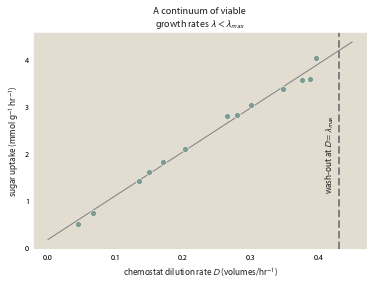

In [6]:
sns.scatterplot(data=kayser_chemostat_df, x='D_per_h', y='r_glucose_mmol_g_h', color=colors['dark_green'])

# Plot a regression
Ds = np.arange(0, masked_kayser.D_per_h.max()+0.1, 0.05)
pred_uptake = kayser_regression.slope*Ds + kayser_regression.intercept
plt.plot(Ds, pred_uptake, ls='-', lw=1, color='grey', zorder=-1)

plt.ylabel('sugar uptake (mmol g$^{-1}$ hr$^{-1}$)')
plt.xlabel('chemostat dilution rate $D$ (volumes/hr$^{-1}$)')

plt.axvline(0.43, color='grey', ls='--')
plt.text(0.417, 2, 'wash-out at $D = \lambda_{max}$', va='center', ha='center', rotation=90, fontsize=9)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')